# Earthquake_real
> Non-Euclidean geometry

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Graph Laplacian, PCA, eigendecomposition]

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import networkx as nx
import folium
from IPython.display import HTML

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')

**대지진 순위중 일부 추출**

In [3]:
pd.read_html('https://ko.wikipedia.org/wiki/%EC%A7%80%EC%A7%84_%EB%AA%A9%EB%A1%9D',encoding='utf-8')[1].iloc[[2,3,8],:]

,순위,일자,장소,이름,규모
2,3,2004년 12월 26일,인도네시아 수마트라섬,2004년 인도양 지진 해일,9.1-9.3
3,4,2011년 3월 11일,일본 산리쿠 해역,2011년 도호쿠 지방 태평양 앞바다 지진,9.1
8,6 (공동),2010년 2월 27일,칠레 마울레주 해역,2010년 칠레 지진,8.8


- t = Year
- x = Latitude
- y = Longitude
- f = Magnitude

##### 1. 데이터 정의

In [108]:
_df = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="2004" & Year<="2011"').reset_index().iloc[:,1:]

##### 2. $f(x) = y$ 정의
- $y$ = Magnitude,  지진 규모로 정의

In [6]:
f = _df.loc[:,"Magnitude"]

##### 3. 비유클리드 공간에서의 거리 정의
- $x$ = Latitude, 위도로 정의
- $y$ = Longitude, 경도로 정의

$$dist((x_i,y_i),(x_j,y_j)) = \sqrt{(x_j-x_i)^2+(y_j-y_i)^2}$$

##### 4. time 고려, 거리를 이용한 a weighted adjacency matrix $W_{i,j}$ 정의
- $V_t$ : the number of countries, $|V| = n$
- $\cal{V} = \begin{bmatrix} 2004a & 2005a & 2006a & \dots \\ 2004b & 2005b & 2006b & \dots \\ \vdots & \vdots & \vdots & \vdots \\ \dots & \dots & \dots &  \dots \end{bmatrix}$, $|\cal{V}| = nm$, (단, $m = t$)
- $W_t=\exp(-\frac{[dist(i,j)]^2}{2\theta^2}) $ $\quad \text{if } dist(i,j) \leq \kappa$
- $W_{u_r,v_s}=\begin{cases} W_t(u,v) & \quad \text{if } u,v \in V_t  \\ \beta & \quad \text{if } u = v \wedge r=s-1 \\ 0 & \quad \text{otherwise} \end{cases}$
- $W(u,v) = \begin{bmatrix} weight(2004a,2004a) & weight(2004a,2005a) & \dots & \dots \\ weight(2004a,2004b) & weight(2005b,2005b) & \dots& \dots \\ \vdots & \vdots & \vdots & \vdots \\ \dots & \dots & \dots & \dots \end{bmatrix}$

In [129]:
V_2004 = np.array([_df.query('Year=="2004"').iloc[:,1:3]])

In [139]:
V_2004

array([[[ -21.476,  169.859],
        [  -8.31 ,  115.788],
        [  17.488, -101.303],
        ...,
        [   7.636,   93.947],
        [   6.204,   92.913],
        [   4.73 ,   95.14 ]]])

In [130]:
V_2005 = np.array([_df.query('Year=="2005"').iloc[:,1:3]])

In [154]:
V_2005.shape

(1, 533, 2)

In [142]:
np.hstack([V_2004,V_2005])

array([[[ -21.476,  169.859],
        [  -8.31 ,  115.788],
        [  17.488, -101.303],
        ...,
        [  -1.386,  -77.517],
        [  26.822,  140.646],
        [   7.529,  -82.266]]])

In [116]:
def dist(i,j):
    a1=abs(_df.Latitude[j] - _df.Latitude[i])
    a2=abs(_df.Latitude[j] + _df.Latitude[i])
    b1=abs(_df.Longitude[j] - _df.Longitude[i])
    b2=abs(_df.Longitude[j] + _df.Longitude[i])
    a= np.min([a1,a2])
    b= np.min([b1,b2])
    return np.sqrt(a**2+b**2)

In [110]:
def weight1(i,j,theta=80,kappa=1000, beta=1):
    if i == j :
        return beta   
    if i == j+1:
        return beta 
    elif dist(i,j) <= kappa :
        return np.exp( -np.abs(dist(i,j))**2 / (2*theta**2) )
    else:
        return 0

In [93]:
def weight2(i,j,theta=90,kappa=1000, beta=1):
    if i == j :
        return beta   
    if i == j+1:
        return beta 
    elif dist(i,j) <= kappa :
        return np.exp( -np.abs(dist(i,j))**2 / (2*theta**2) )
    else:
        return 0

In [94]:
def weight3(i,j,theta=100,kappa=1000, beta=1):
    if i == j :
        return beta   
    if i == j+1:
        return beta 
    elif dist(i,j) <= kappa :
        return np.exp( -np.abs(dist(i,j))**2 / (2*theta**2) )
    else:
        return 0

---

**하버사인haversine 공식 사용**

In [121]:
from haversine import haversine

In [ ]:
def dist2(i,j):
    return haversine((_df.Latitude[i],_df.Longitude[i]),(_df.Latitude[j],_df.Longitude[j]))

In [ ]:
def weight4(i,j,theta=50000,kappa=100000):
    if i == j :
        return beta   
    if i == j+1:
        return beta 
    elif dist2(i,j) <= kappa :
        return np.exp( -np.abs(dist2(i,j))**2 / (2*theta**2) )
    else:
        return 0

In [ ]:
def weight5(i,j,theta=75000,kappa=100000):
    if i == j :
        return beta   
    if i == j+1:
        return beta 
    elif dist2(i,j) <= kappa :
        return np.exp( -np.abs(dist2(i,j))**2 / (2*theta**2) )
    else:
        return 0

In [ ]:
def weight6(i,j,theta=100000,kappa=100000):
    if i == j :
        return beta   
    if i == j+1:
        return beta 
    elif dist2(i,j) <= kappa :
        return np.exp( -np.abs(dist2(i,j))**2 / (2*theta**2) )
    else:
        return 0

---

In [ ]:
W1 = np.array([[weight1(i,j) for i in range(len(_df.query('Year=="2004"')))] for j in range(len(_df.query('Year=="2004"')))])

In [ ]:
W1

In [ ]:
#collapse
plt.hist(W.reshape(-1))

In [ ]:
W2 = np.array([[weight2(i,j) for i in range(len(_df))] for j in range(len(_df))])

In [ ]:
W3 = np.array([[weight3(i,j) for i in range(len(_df))] for j in range(len(_df))])

In [ ]:
W4 = np.array([[weight4(i,j) for i in range(len(_df))] for j in range(len(_df))])

In [ ]:
W5 = np.array([[weight5(i,j) for i in range(len(_df))] for j in range(len(_df))])

In [ ]:
W6 = np.array([[weight6(i,j) for i in range(len(_df))] for j in range(len(_df))])

##### 5. $W_{i,j}$ 행렬을 이용한 차수 행렬 정의
- $D$ = Degree Matrix

In [ ]:
D1 = np.diag(W1.sum(axis=1))

In [ ]:
D2 = np.diag(W2.sum(axis=1))

In [ ]:
D3 = np.diag(W3.sum(axis=1))

In [ ]:
D4 = np.diag(W4.sum(axis=1))

In [ ]:
D5 = np.diag(W5.sum(axis=1))

In [ ]:
D6 = np.diag(W6.sum(axis=1))

##### 6. Graph Laplacian matrix 정의
- $L = D - W$

In [ ]:
L1 = D1 - W1

In [ ]:
L2 = D2 - W2

In [ ]:
L3 = D3 - W3

In [ ]:
L4 = D4 - W4

In [ ]:
L5 = D5 - W5

In [ ]:
L6 = D6 - W6

##### 7. 고유값 분해
- ${\bf L} = {\boldsymbol\Psi} {\boldsymbol\Lambda} {\boldsymbol\Psi}^\top$

In [ ]:
λ1, Ψ1 = np.linalg.eig(L1)

In [ ]:
Λ1 = np.diag(λ1)

In [ ]:
λ2, Ψ2 = np.linalg.eig(L2)

In [ ]:
Λ2 = np.diag(λ2)

In [ ]:
λ3, Ψ3 = np.linalg.eig(L3)

In [ ]:
Λ3 = np.diag(λ3)

In [ ]:
λ4, Ψ4 = np.linalg.eig(L4)

In [ ]:
Λ4 = np.diag(λ4)

In [ ]:
λ5, Ψ5 = np.linalg.eig(L5)

In [ ]:
Λ5 = np.diag(λ5)

In [ ]:
λ6, Ψ6 = np.linalg.eig(L6)

In [ ]:
Λ6 = np.diag(λ6)

##### 8. 주성분 분석
- $comp_k = f @ np.outer(Ψ[:,k], Ψ[:,k]) $
    - $k = 1, 2, 3, 8000$
        - $f = n \times 1 , np.outer(Ψ[:,k], Ψ[:,k]) = n \times n, \\ \therefore comp_k = n \times 1$
- $p = \sum_{1}^{n} comp_{1}^{2},\sum_{1}^{n} comp_{2}^{2},…,\sum_{1}^{n} comp_{n}^{2}$
- $p = \frac{p}{\sum(p)}$

In [ ]:
def p1(i):
    return sum((f @ np.outer( Ψ1[:,i], Ψ1[:,i]))**2)

In [ ]:
array_11 = np.array([p1(i) for i in range(1,len(_df))])

In [ ]:
varprop1 = array_11/array_11.sum()

In [ ]:
#collapse
_index1 = pd.DataFrame({'index':range(1,len(_df)),'varprop':varprop1}).sort_values('varprop',ascending=False)
_indexlst1 = _index1.iloc[:25,0].tolist()

In [ ]:
def p2(i):
    return sum((f @ np.outer( Ψ2[:,i], Ψ2[:,i]))**2)

In [ ]:
array_12 = np.array([p2(i) for i in range(1,len(_df))])

In [ ]:
varprop12 = array_12/array_12.sum()

In [ ]:
#collapse
_index2 = pd.DataFrame({'index':range(1,len(_df)),'varprop':varprop2}).sort_values('varprop',ascending=False)
_indexlst2 = _index2.iloc[:25,0].tolist()

In [ ]:
def p3(i):
    return sum((f @ np.outer( Ψ3[:,i], Ψ3[:,i]))**2)

In [ ]:
array_13 = np.array([p3(i) for i in range(1,len(_df))])

In [ ]:
varprop3 = array_13/array_13.sum()

In [ ]:
#collapse
_index3 = pd.DataFrame({'index':range(1,len(_df)),'varprop':varprop3}).sort_values('varprop',ascending=False)
_indexlst3 = _index3.iloc[:25,0].tolist()

In [ ]:
def p4(i):
    return sum((f @ np.outer( Ψ4[:,i], Ψ4[:,i]))**2)

In [ ]:
array_14 = np.array([p4(i) for i in range(1,len(_df))])

In [ ]:
varprop4 = array_14/array_14.sum()

In [ ]:
#collapse
_index4 = pd.DataFrame({'index':range(1,len(_df)),'varprop':varprop4}).sort_values('varprop',ascending=False)
_indexlst4 = _index4.iloc[:25,0].tolist()

In [ ]:
def p5(i):
    return sum((f @ np.outer( Ψ5[:,i], Ψ5[:,i]))**2)

In [ ]:
array_15 = np.array([p5(i) for i in range(1,len(_df))])

In [ ]:
varprop5 = array_15/array_15.sum()

In [ ]:
#collapse
_index5 = pd.DataFrame({'index':range(1,len(_df)),'varprop':varprop5}).sort_values('varprop',ascending=False)
_indexlst5 = _index5.iloc[:25,0].tolist()

In [ ]:
def p6(i):
    return sum((f @ np.outer( Ψ6[:,i], Ψ6[:,i]))**2)

In [ ]:
array_16 = np.array([p6(i) for i in range(1,len(_df))])

In [ ]:
varprop6 = array_16/array_16.sum()

In [ ]:
#collapse
_index6 = pd.DataFrame({'index':range(1,len(_df)),'varprop':varprop6}).sort_values('varprop',ascending=False)
_indexlst6 = _index6.iloc[:25,0].tolist()

##### 9. PCA

In [ ]:
comp11 = f @ np.outer( Ψ1[:,0], Ψ1[:,0])

In [ ]:
comp21 = f @ np.outer( Ψ1[:,_indexlst1[0]], Ψ1[:,_indexlst1[0]])

In [ ]:
comp31 = f @ np.outer( Ψ1[:,_indexlst1[1]], Ψ1[:,_indexlst1[1]])

In [ ]:
comp41 = f @ np.outer( Ψ1[:,_indexlst1[2]], Ψ1[:,_indexlst1[2]])

In [ ]:
comp51 = f @ np.outer( Ψ1[:,_indexlst1[3]], Ψ1[:,_indexlst1[3]])

In [ ]:
_df["comp1"] = comp11

In [ ]:
_df["comp2"] = comp21

In [ ]:
_df["comp3"] = comp31

In [ ]:
_df["comp4"] = comp41

In [ ]:
_df["comp5"] = comp51

In [ ]:
comp12 = f @ np.outer( Ψ2[:,0], Ψ2[:,0])

In [ ]:
comp22 = f @ np.outer( Ψ2[:,_indexlst2[0]], Ψ2[:,_indexlst2[0]])

In [ ]:
comp32 = f @ np.outer( Ψ2[:,_indexlst2[1]], Ψ2[:,_indexlst2[1]])

In [ ]:
comp42 = f @ np.outer( Ψ2[:,_indexlst2[2]], Ψ2[:,_indexlst2[2]])

In [ ]:
comp52 = f @ np.outer( Ψ2[:,_indexlst2[3]], Ψ2[:,_indexlst2[3]])

In [ ]:
_df["comp1"] = comp12

In [ ]:
_df["comp2"] = comp22

In [ ]:
_df["comp3"] = comp32

In [ ]:
_df["comp4"] = comp42

In [ ]:
_df["comp5"] = comp52

---

##### **$dist$를 이용한 $\theta$ = 80, $\kappa$ = 1000**

In [ ]:
_G1 = nx.Graph(W1-np.identity(len(f)))

In [ ]:
_pos1 = nx.spring_layout(_G1,iterations=20)

In [ ]:
m_pos1 = list(zip(_df.Longitude,_df.Latitude))

In [ ]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.comp1,node_size = abs(_df.comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.comp2,node_size = np.abs(_df.comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Japan Sanriku", xy=(141.81051675491926,39.138785036804705), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

In [ ]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.comp3,node_size = np.abs(_df.comp3)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

In [ ]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.comp4,node_size = np.abs(_df.comp4)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G1,m_pos1,node_color=_df.comp5,node_size = abs(_df.comp5)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Chile Maule", xy=(-72.41179564292405,-35.301421198712724), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

---

##### **$dist$를 이용한 $\theta$ = 90, $\kappa$ = 1000**

In [ ]:
_G2 = nx.Graph(W2-np.identity(len(f)))

In [ ]:
_pos2 = nx.spring_layout(_G2,iterations=20)

In [ ]:
m_pos2 = list(zip(_df.Longitude,_df.Latitude))

In [ ]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.comp1,node_size = abs(_df.comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [ ]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.comp2,node_size = np.abs(_df.comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

In [ ]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.comp3,node_size = np.abs(_df.comp3)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

In [ ]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.comp4,node_size = np.abs(_df.comp4)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Japan Sanriku", xy=(141.81051675491926,39.138785036804705), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

In [ ]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G2,m_pos2,node_color=_df.comp5,node_size = abs(_df.comp5)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Chile Maule", xy=(-72.41179564292405,-35.301421198712724), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

---

##### **$dist$를 이용한 $\theta$ = 100, $\kappa$ = 1000**

In [1370]:
_G = nx.Graph(W-np.identity(len(f)))

In [1371]:
_pos = nx.spring_layout(_G,iterations=20)

In [1372]:
m_pos = list(zip(_df.Longitude,_df.Latitude))

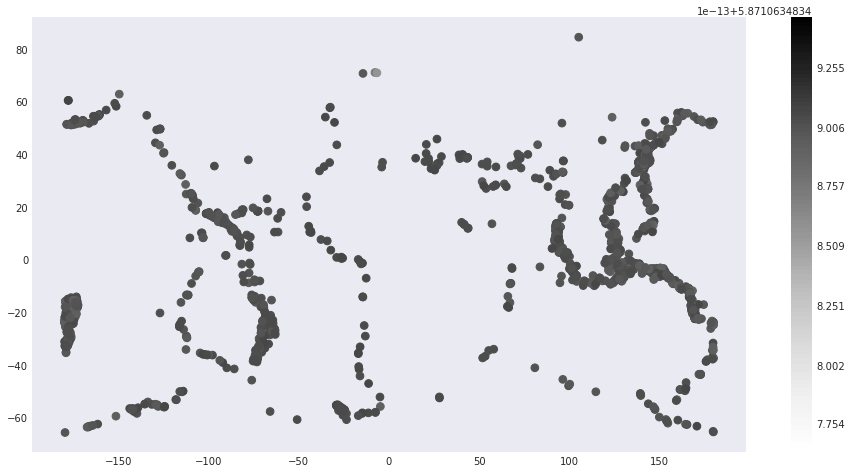

In [1373]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp1,node_size = abs(_df.comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

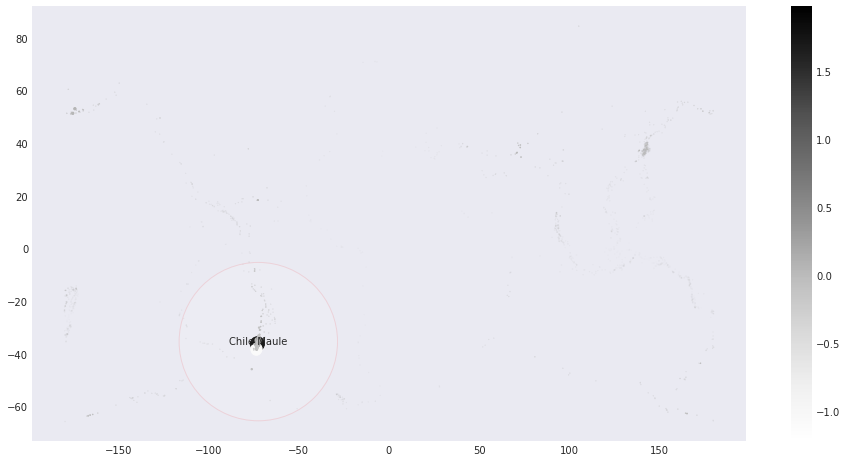

In [1378]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp2,node_size = np.abs(_df.comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Chile Maule", xy=(-72.41179564292405,-35.301421198712724), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

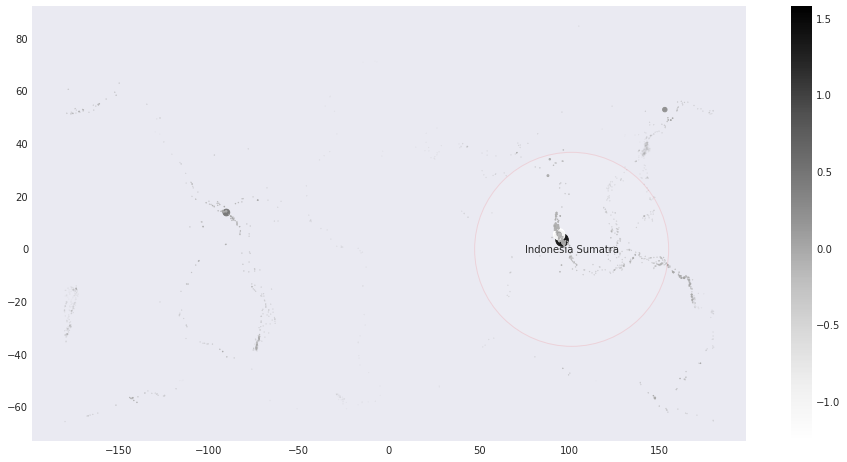

In [1375]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp3,node_size = np.abs(_df.comp3)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

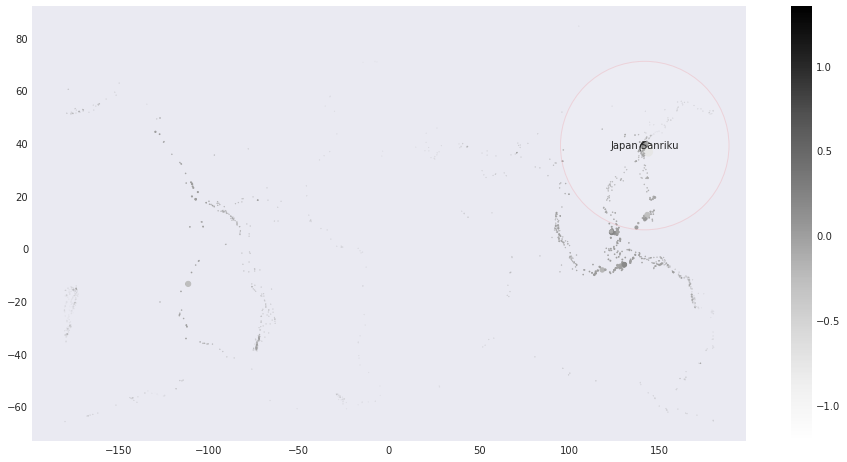

In [1376]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp4,node_size = np.abs(_df.comp4)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Japan Sanriku", xy=(141.81051675491926,39.138785036804705), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

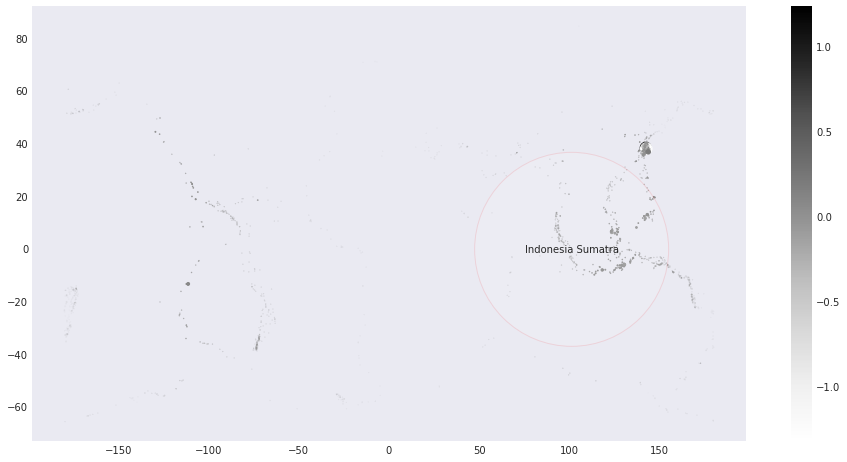

In [1379]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp5,node_size = abs(_df.comp5)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

---

##### **$haversine$ 패키지를 이용한 $\theta$ = 50000,$\kappa$ = 100000**

In [1002]:
_G = nx.Graph(W-np.identity(len(f)))

In [1003]:
_pos = nx.spring_layout(_G,iterations=20)

In [1004]:
m_pos = list(zip(_df.Longitude,_df.Latitude))

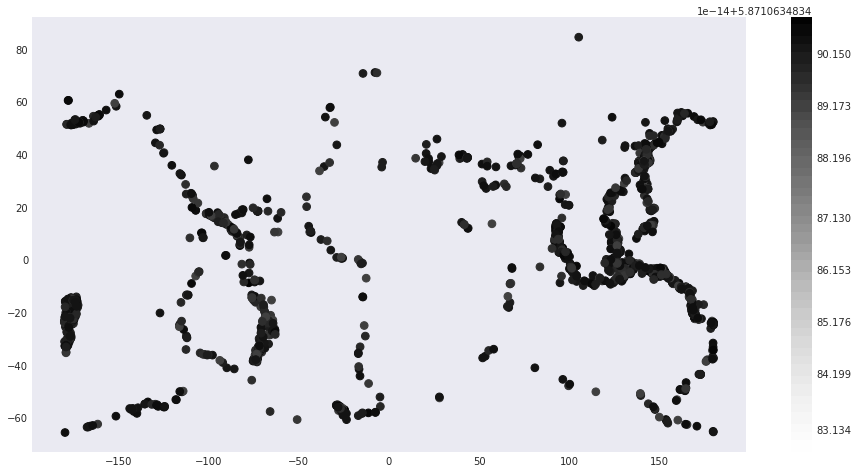

In [1005]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp1,node_size = abs(_df.comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

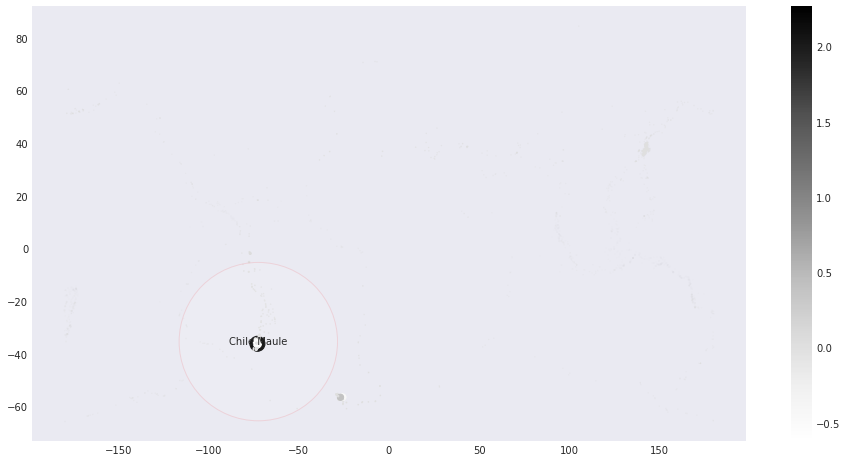

In [1010]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp2,node_size = np.abs(_df.comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Chile Maule", xy=(-72.41179564292405,-35.301421198712724), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

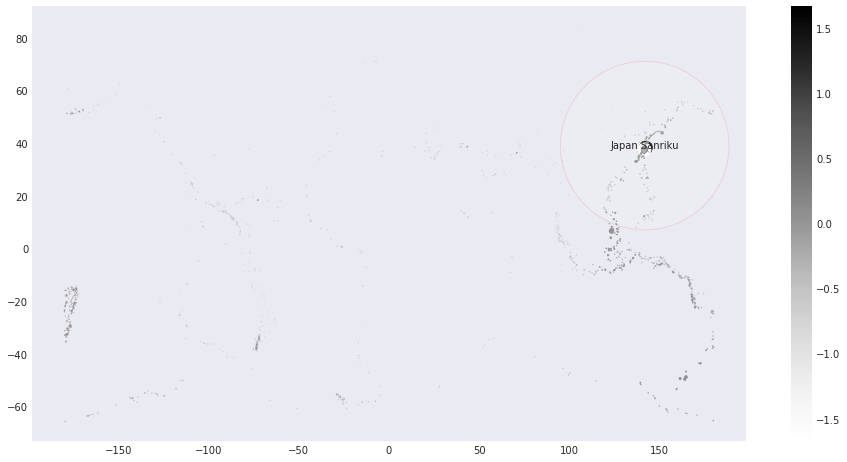

In [1012]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp3,node_size = np.abs(_df.comp3)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Japan Sanriku", xy=(141.81051675491926,39.138785036804705), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

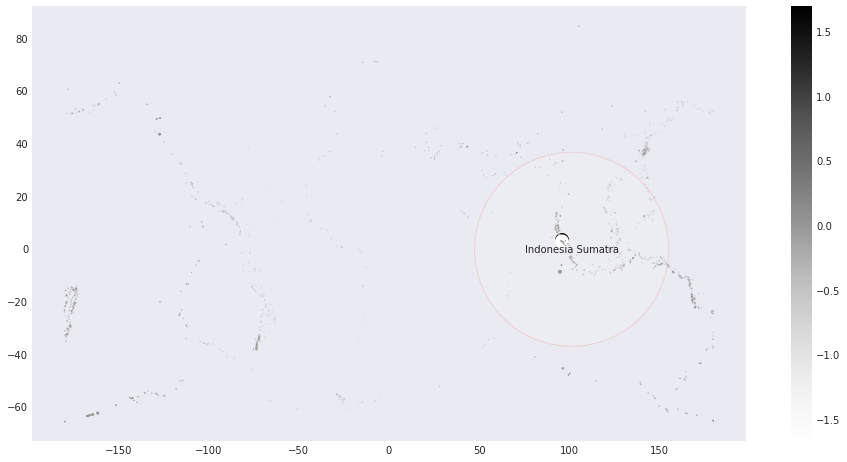

In [1011]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp4,node_size = np.abs(_df.comp4)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

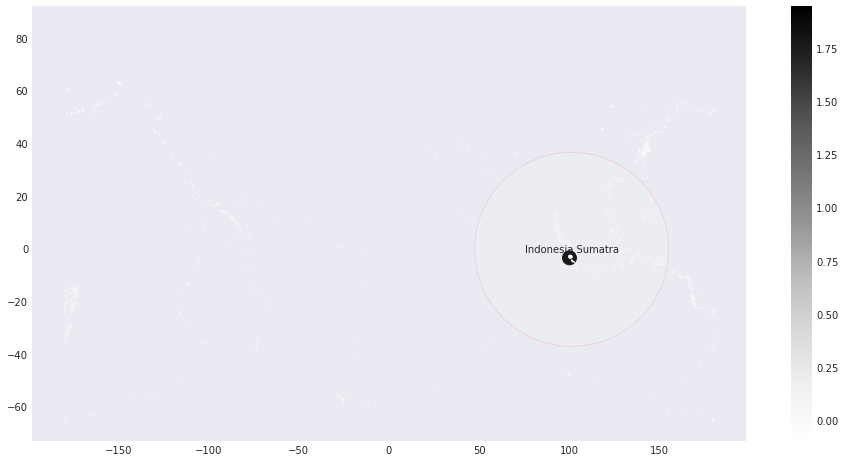

In [1013]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp5,node_size = abs(_df.comp5)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    # ax.annotate("Tasman Sea", xy=(160.4313,-40.8581), xycoords="data",
    #               va="center", ha="center",
    #               bbox=dict(boxstyle="circle, pad=3", alpha = 0.1,fc="w",lw=1, ec='r'))
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

---

##### **$haversine$ 패키지를 이용한 $\theta$ = 75000,$\kappa$ = 100000**

In [1189]:
_G = nx.Graph(W-np.identity(len(f)))

In [1190]:
_pos = nx.spring_layout(_G,iterations=20)

In [1191]:
m_pos = list(zip(_df.Longitude,_df.Latitude))

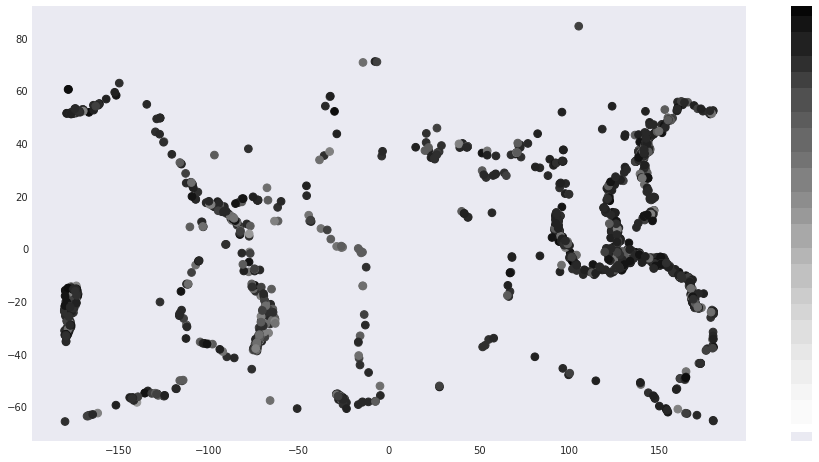

In [1192]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp1,node_size = abs(_df.comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

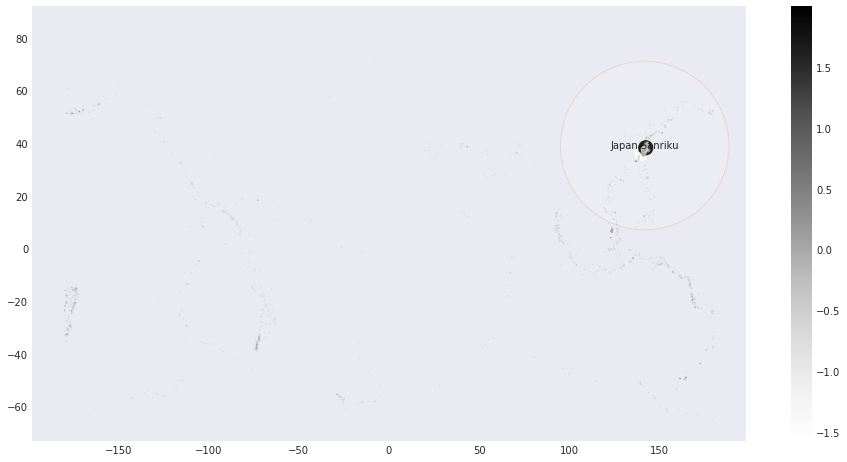

In [1198]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp2,node_size = np.abs(_df.comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Japan Sanriku", xy=(141.81051675491926,39.138785036804705), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

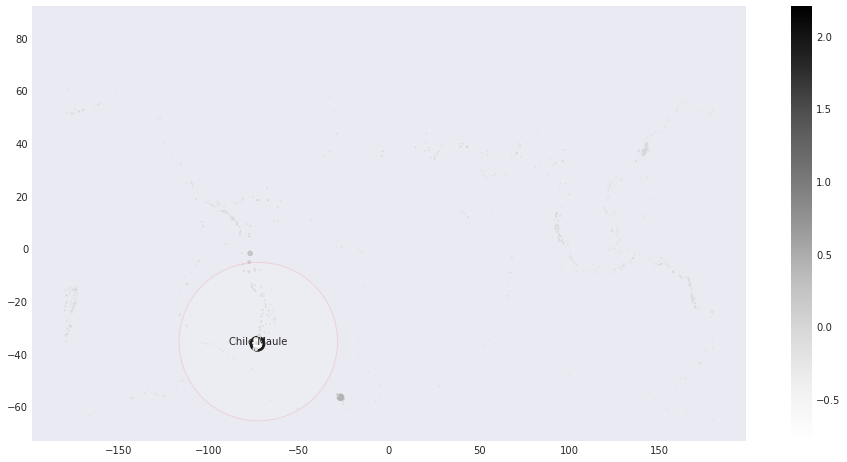

In [1199]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp3,node_size = np.abs(_df.comp3)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

    ax.annotate("Chile Maule", xy=(-72.41179564292405,-35.301421198712724), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

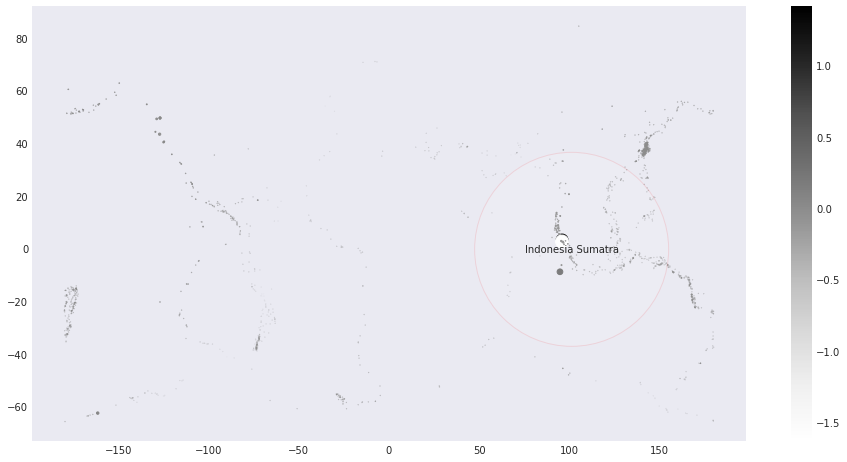

In [1201]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp4,node_size = np.abs(_df.comp4)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

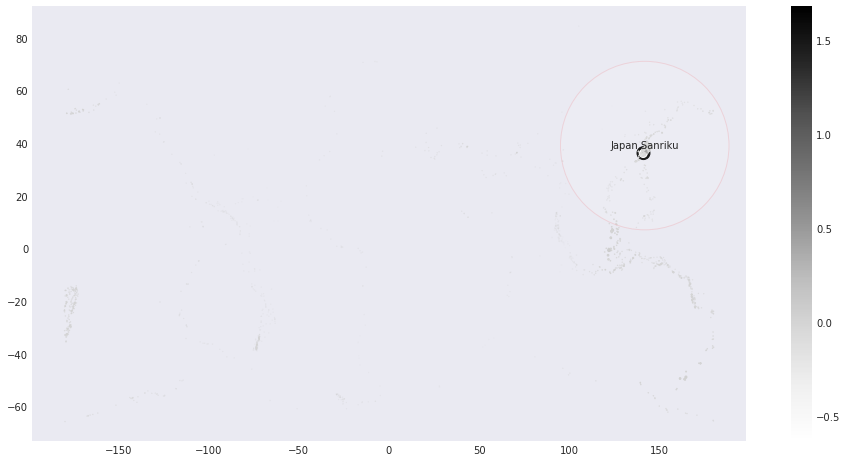

In [1200]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp5,node_size = abs(_df.comp5)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    # ax.annotate("Tasman Sea", xy=(160.4313,-40.8581), xycoords="data",
    #               va="center", ha="center",
    #               bbox=dict(boxstyle="circle, pad=3", alpha = 0.1,fc="w",lw=1, ec='r'))
    ax.annotate("Japan Sanriku", xy=(141.81051675491926,39.138785036804705), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

---

##### **$haversine$ 패키지를 이용한 $\theta$ = 100000,$\kappa$ = 100000**

In [1328]:
_G = nx.Graph(W-np.identity(len(f)))

In [1329]:
_pos = nx.spring_layout(_G,iterations=20)

In [1330]:
m_pos = list(zip(_df.Longitude,_df.Latitude))

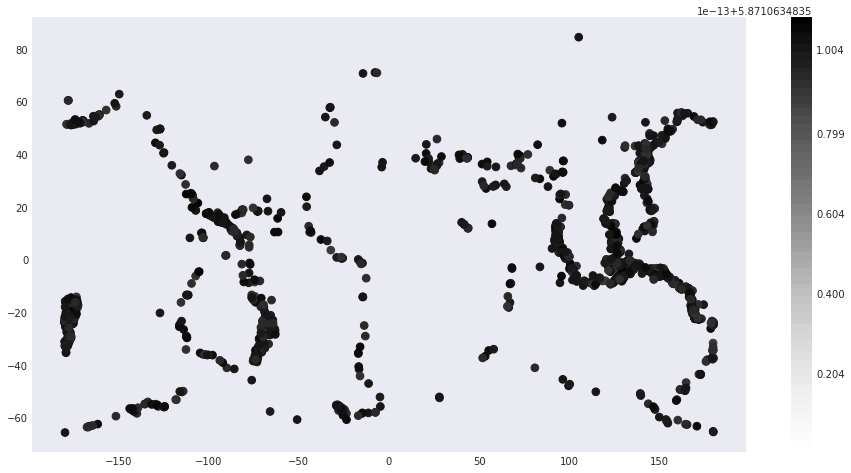

In [1331]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp1,node_size = abs(_df.comp1)*10, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

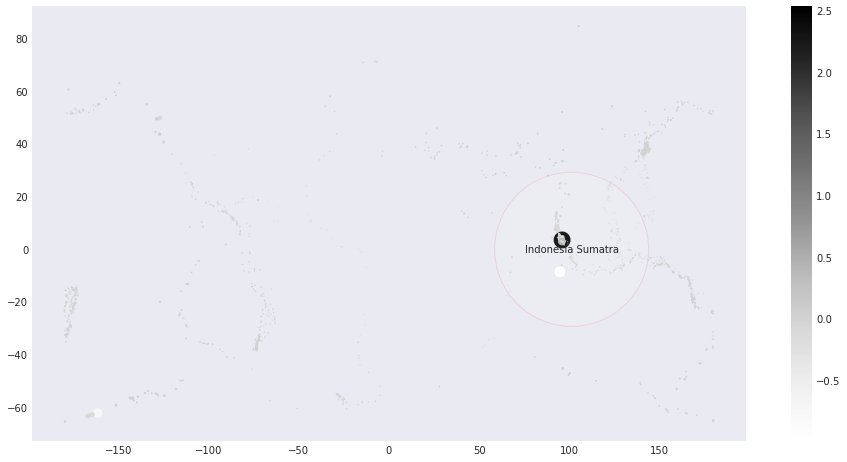

In [1341]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp2,node_size = np.abs(_df.comp2)*100,ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=3", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

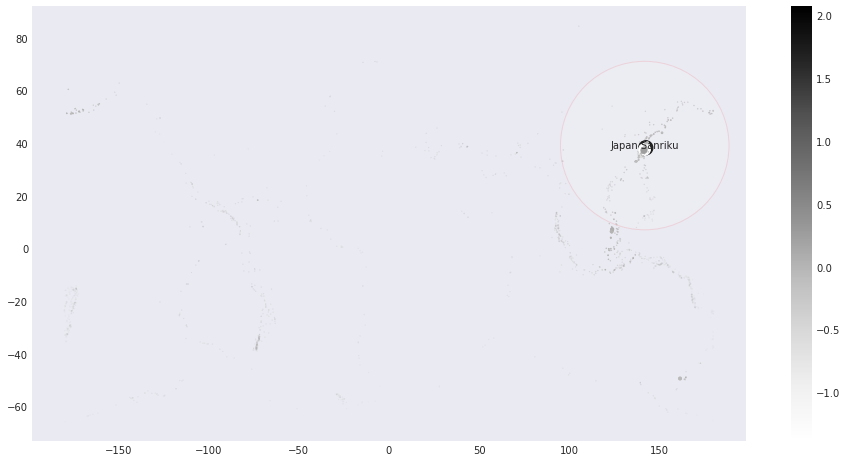

In [1337]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp3,node_size = np.abs(_df.comp3)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Japan Sanriku", xy=(141.81051675491926,39.138785036804705), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

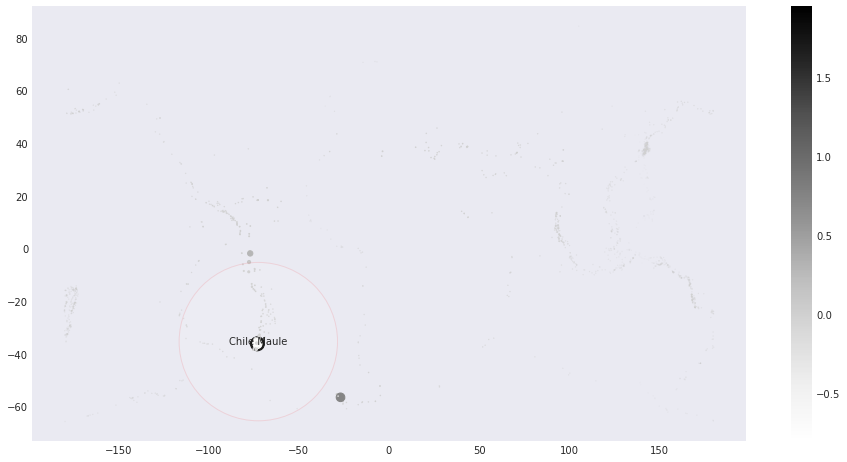

In [1338]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp4,node_size = np.abs(_df.comp4)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Chile Maule", xy=(-72.41179564292405,-35.301421198712724), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=5", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

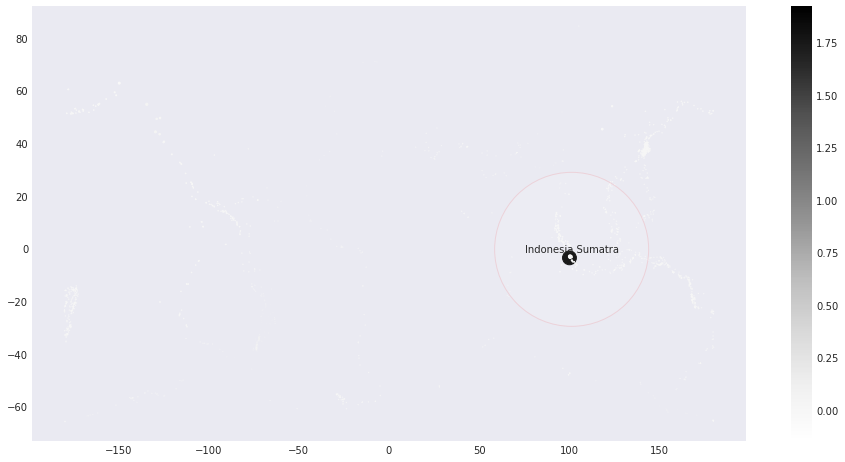

In [1340]:
with plt.style.context('seaborn-dark'):
    fig,ax = plt.subplots(figsize = (16,8))
    nodes = nx.draw_networkx_nodes(_G,m_pos,node_color=_df.comp5,node_size = abs(_df.comp5)*100, ax=ax)
    plt.colorbar(nodes)
    plt.axis()
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.annotate("Indonesia Sumatra", xy=( 101.28817388446576,-0.26014368149947664), xycoords="data",
                  va="center", ha="center",
                  bbox=dict(boxstyle="circle, pad=3", alpha = 0.1,fc="w",lw=1, ec='r'))
plt.show()

---